<a href="https://colab.research.google.com/github/snaily16/GAN-Implementations-Pytorch/blob/master/GAN_MNIST_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import time
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
directory = 'mnist_gan'
if not os.path.exists(directory):
    os.mkdir(directory)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyperparameters
batch_size=100
num_epochs=200
image_size=28*28
hidden_size=256
latent_size=64
lr = 0.0002

In [5]:
# Load Dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
])

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size ,shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


# Generative Adversarial Network
Consists of two models:
- Generator
- Discriminator

We have two neural networks that are adversaries: the generator wants to fool the discriminator, and the discriminator wants to avoid being fooled. The setup is known as a min-max game.

In [6]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

D = D.to(device)
G = G.to(device)

In [8]:
def denorm(x):
  out = (x+1)/2
  return out.clamp(0,1)

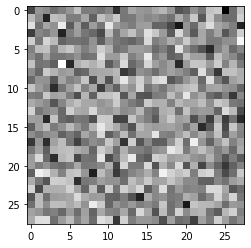

In [9]:
z=G(torch.randn(2,latent_size))
gen_imgs = denorm(z.reshape(-1,28,28)).detach()
plt.imshow(gen_imgs[0], cmap='Greys')

P(D correctly identifies real image) + P(D correctly identifies image generated by G)

A good discriminator would want to maximize the above quanity by altering its parameters.

Likewise, a good generator would want to minimize the above quanity. Actually, the only term that the generator controls is P(D correctly identifies image generated by G)$ So, the best thing for the generator to do is alter its parameters to generate images that can fool D.

Since we are looking at class probabilities, we will use binary cross entropy loss.

For the discriminator, we use the label 1 to represent a fake image, and 0 to represent a real image.

## Optimization

In [10]:
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

In [11]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

In [12]:
def train_discriminator(images):
  # create labels
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)
    
  # ============================
  #   Train the discriminator
  # ============================

  # Compute BCELoss using real images
  # where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
  # Second term of the loss is always zero since real_labels == 1
  outputs = D(images)
  d_real_loss = criterion(outputs, real_labels)
  real_score = outputs

  # compute BCELoss using fake images
  # First term of the loss is always zero since fake_labels == 0
  noise = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(noise)
  outputs = D(fake_images)
  d_fake_loss = criterion(outputs, fake_labels)
  fake_score = outputs

  # Backprop and optimize
  d_loss = d_real_loss + d_fake_loss
  reset_grad()
  d_loss.backward()
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [13]:
def train_generator():
  real_labels = torch.ones(batch_size, 1).to(device)

  # ============================
  #    Train the Generator
  # ============================
    
  # compute loss with fake image
  noise = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(noise)
  outputs = D(fake_images)

  # train G to maximize log(D(G(z)))
  g_loss = criterion(outputs, real_labels)

  # Backprop and optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()
  
  return g_loss, fake_images

In [14]:
# Start Training
total_steps = len(train_loader)
d_losses, g_losses, real_scores, fake_scores =[],[],[],[]
for epoch in range(num_epochs):
  for n, (images, _) in enumerate(train_loader):
    images = images.reshape(batch_size, -1).to(device)

    d_loss, real_score, fake_score = train_discriminator(images)
    g_loss, fake_images = train_generator()

    if (n+1)%200==0:
      d_losses.append(d_loss.item())
      g_losses.append(g_loss.item())
      real_scores.append(real_score.mean().item())
      fake_scores.append(fake_score.mean().item())
      print('Epoch [{}/{}], Step[{}/{}], d_loss: {}, g_loss: {}, D(x): {}, D(G(z)): {}'.format(
          epoch + 1, num_epochs, n+1, total_steps, d_loss.item(), g_loss.item(),
          real_score.data.mean().item(), fake_score.data.mean().item()))
      
    # Save real images
    if(epoch+1)==1:
      images = images.reshape(images.size(0), 1, 28, 28)
      save_image(denorm(images), os.path.join(directory, 'real_images.png'))

    # Save sampled images
    if(epoch+1)%10==0:
      fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
      save_image(denorm(fake_images), os.path.join(directory, 'fake_images{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Epoch [1/200], Step[200/600], d_loss: 0.0497019924223423, g_loss: 4.095281600952148, D(x): 0.9942538738250732, D(G(z)): 0.04278142750263214
Epoch [1/200], Step[400/600], d_loss: 0.07911112904548645, g_loss: 7.174676418304443, D(x): 0.9952250719070435, D(G(z)): 0.06926529109477997
Epoch [1/200], Step[600/600], d_loss: 0.026755884289741516, g_loss: 5.297602653503418, D(x): 0.9893641471862793, D(G(z)): 0.015397567301988602
Epoch [2/200], Step[200/600], d_loss: 0.02988741360604763, g_loss: 5.5538458824157715, D(x): 0.9947142004966736, D(G(z)): 0.023921819403767586
Epoch [2/200], Step[400/600], d_loss: 0.22485682368278503, g_loss: 4.477736949920654, D(x): 0.9647367596626282, D(G(z)): 0.16241222620010376
Epoch [2/200], Step[600/600], d_loss: 0.14222539961338043, g_loss: 6.02767276763916, D(x): 0.9901809692382812, D(G(z)): 0.11047536879777908
Epoch [3/200], Step[200/600], d_loss: 0.22559554874897003, g_loss: 3.4180550575256348, D(x): 0.882063627243042, D(G(z)): 0.03259764611721039
Epoch [3/20

In [16]:
# visualize training process
import cv2

vid_fname = 'gan_training_mnist.avi'
files = [os.path.join(directory, f) for f in os.listdir(directory) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

Text(0.5, 1.0, 'Training Losses')

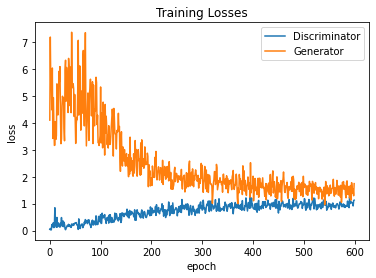

In [17]:
# plot loss
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Training Losses')

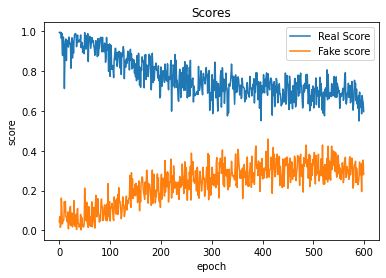

In [18]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');